<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/dtm_project_pix2pix_fin_no_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()
# #KAGGLE API TOKEN 업로드

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d jerrypark/edge-png
# !kaggle datasets download -d jerrypark/color-png
# !kaggle datasets download -d jerrypark/color-jpg

In [2]:
# %%capture
# # !unzip dtmdataset.zip -d ./dtmdataset
# # !unzip dtmdatasetval.zip -d ./dtmdatasetval
# !unzip edge-png.zip -d ./edge-png
# !unzip color-png.zip -d ./color-png
# !unzip color-jpg.zip -d ./color-jpg

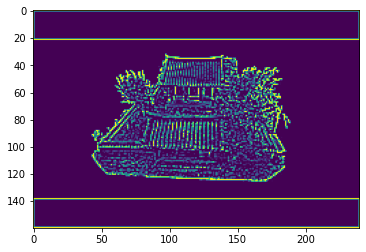

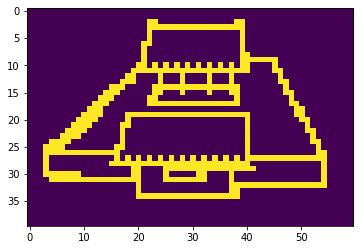

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter

def getImg(fullPath):
    img = Image.open(fullPath)
    size = (60*4,40*4)
#     size = (60,40)
    img.thumbnail(size)
    background = Image.new('RGBA', size, (255,255,255,0))
    # background = Image.new('RGB', size, (0,0,0))
    #background = Image.new('RGB', size, (255,255,255))
    background.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    grayimage = background.convert("L")
    
    grayimage = grayimage.filter(ImageFilter.FIND_EDGES)
    image_array = 255. - (np.array(grayimage)-1)
    return np.array(grayimage) #image_array

getBinary = lambda x, n: format(x, 'b').zfill(n)

def getDtmLine(dtm, no):
    start = 30*no
    imgTemp = [[],[],[],[]]
    for idx, i in enumerate(dtm[start:start+30]):
        bin8 = getBinary(i,8)
        imgMap = [[int(bin8[7]),int(bin8[3])],
                [int(bin8[6]),int(bin8[2])],
                [int(bin8[5]),int(bin8[1])],
                [int(bin8[4]),int(bin8[0])]]
        imgTemp = np.concatenate((imgTemp, imgMap), axis=1)
    return imgTemp

def getDtm(fullPath):
#     with open("/kaggle/input/dtm-dataset/"+fileNo+".dtm","rb") as f:
    with open(fullPath,"rb") as f:
        dtm = f.read()

    img = getDtmLine(dtm, 1)
    for l in range(2,11):
        imgN = getDtmLine(dtm, l)
        img = np.concatenate((img, imgN), axis=0)

    return img

img = getImg("./color-png/1.png")
#print(img[10])
plt.imshow(img)
plt.show()

dtm = getDtm("./color-png/1.dtm")
#print(dtm[10])
plt.imshow(dtm)
plt.show()

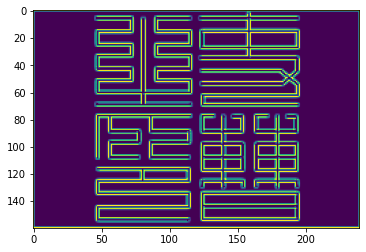

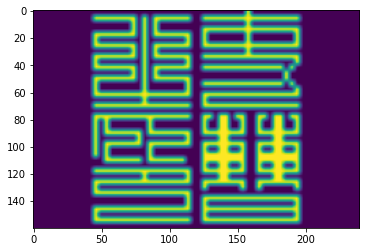

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

class ImageDataset(Dataset):
    def __init__(self, root, root2, transforms_=None, mode="train"):
        self.transform = transforms_
        self.mode = mode

        self.files = sorted(glob.glob(os.path.join(root) + "/*.png"))
        self.files.extend(sorted(glob.glob(os.path.join(root2) + "/*.jpg")))

    def __getitem__(self, index):
        fullPathA = self.files[index % len(self.files)]
        img_A = getImg(fullPathA)

        fullPathB = fullPathA.replace(".png", ".dtm").replace(".jpg", ".dtm")
        img_B = getDtm(fullPathB)
        
#         if(self.mode == "train"):
#             fullPathB = fullPathA.replace(".png", ".dtm").replace(".jpg", ".dtm")
#             img_B = getDtm(fullPathB)
#         else:
#             img_B = img_A

        #         img = Image.open(self.files[index % len(self.files)])
#         w, h = img.size
#         img_A = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반
#         img_B = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반

#         # 데이터 증진(data augmentation)을 위한 좌우 반전(horizontal flip)
#         if np.random.random() < 0.5:
#             img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
#             img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        PIL_imageA = Image.fromarray(img_A)
        PIL_imageB = Image.fromarray(img_B)

        img_A = self.transform(PIL_imageA)
        img_B = self.transform(PIL_imageB)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

transforms_ = transforms.Compose([
    transforms.Resize((40*4, 60*4)),#, Image.BICUBIC),    
#     transforms.Resize((256, 256)),#, Image.BICUBIC),
    transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
    #transforms.Normalize((0.5), (0.5))
])

# train_dataset = ImageDataset("/kaggle/input/color-png", "/kaggle/input/color-jpg", transforms_=transforms_, mode="train")
train_dataset = ImageDataset("./edge-png", "", transforms_=transforms_, mode="train")
# val_dataset = ImageDataset("", "/kaggle/input/dtmdatasetval", transforms_=transforms_, mode="test")
# val_dataset = ImageDataset("/kaggle/input/dtmdataset", "", transforms_=transforms_, mode="test")
val_dataset = ImageDataset("./color-png", "/color-jpg", transforms_=transforms_, mode="test")

# plt.imshow(train_dataset[0]['A'].reshape(256,256))
plt.imshow(train_dataset[0]['A'].reshape(40*4, 60*4))
plt.show()
# plt.imshow(train_dataset[0]['B'].reshape(256,256))
plt.imshow(train_dataset[0]['B'].reshape(40*4, 60*4))
plt.show()

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
sample_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [5]:
# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    #def __init__(self, in_channels=3):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
#             layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

    

# def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
#     layers = []
#     layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
#                          kernel_size=kernel_size, stride=stride, padding=padding,
#                          bias=bias)]
#     layers += [nn.BatchNorm2d(num_features=out_channels)]
#     layers += [nn.ReLU()]

#     cbr = nn.Sequential(*layers)

#     return cbr

class CBR2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, norm="bnorm", relu=0.0):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                             kernel_size=kernel_size, stride=stride, padding=padding,
                             bias=bias)]

        if not norm is None:
            if norm == "bnorm":
                layers += [nn.BatchNorm2d(num_features=out_channels)]
            elif norm == "inorm":
                layers += [nn.InstanceNorm2d(num_features=out_channels)]

        if not relu is None and relu >= 0.0:
            layers += [nn.ReLU() if relu == 0 else nn.LeakyReLU(relu)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# 생성자(generator)와 판별자(discriminator) 초기화
generator = UNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.005 #0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)#, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)#, betas=(0.5, 0.999))

# !pip install pytorch-model-summary
# import pytorch_model_summary
# # print(pytorch_model_summary.summary(generator, torch.zeros(1,1,256,256), max_depth=None, show_parent_layers=True, show_input=True))
# print(pytorch_model_summary.summary(generator, torch.zeros(1,1,40*4,60*4).cuda(), max_depth=None, show_parent_layers=True, show_input=True))

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# 생성자(generator)와 판별자(discriminator) 초기화
# generator = GeneratorUNet()
generator = UNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

#!pip install pytorch-model-summary
# import pytorch_model_summary
# print(pytorch_model_summary.summary(generator, torch.zeros(1,1,256,256), max_depth=None, show_parent_layers=True, show_input=True))
#print(pytorch_model_summary.summary(generator, torch.zeros(1,1,40*4,60*4).cuda(), max_depth=None, show_parent_layers=True, show_input=True))

[Epoch 50/500] [D loss: 0.250] [G pixel loss: 0.018, adv loss: 0.204] [Elapsed time: 221.6s]


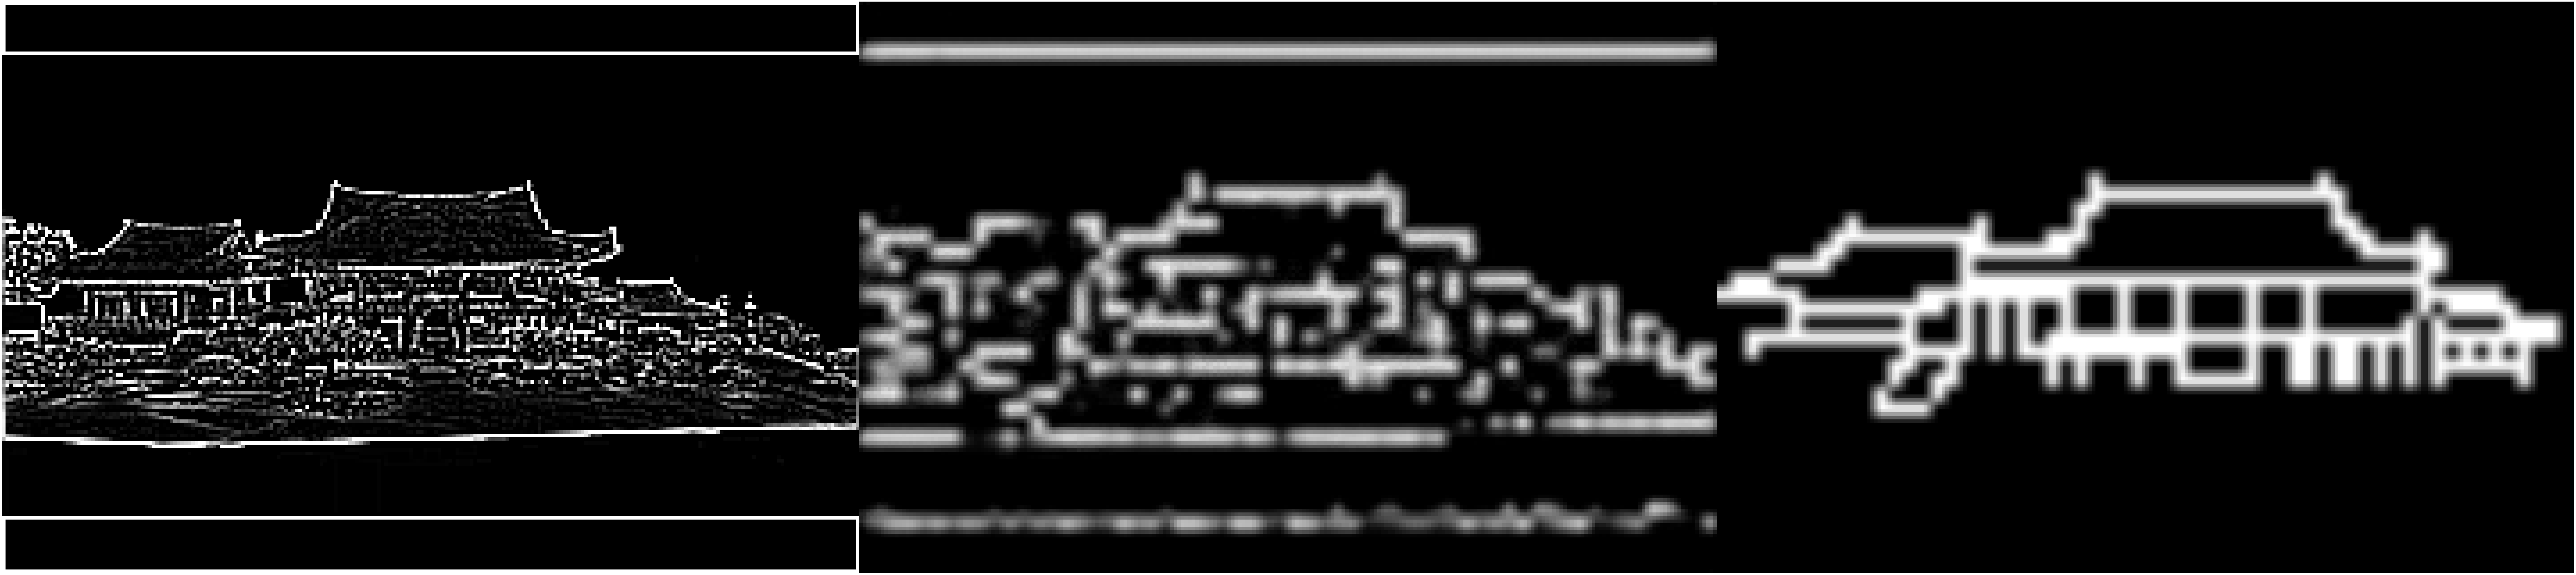

[Epoch 100/500] [D loss: 0.262] [G pixel loss: 0.011, adv loss: 0.301] [Elapsed time: 447.7s]


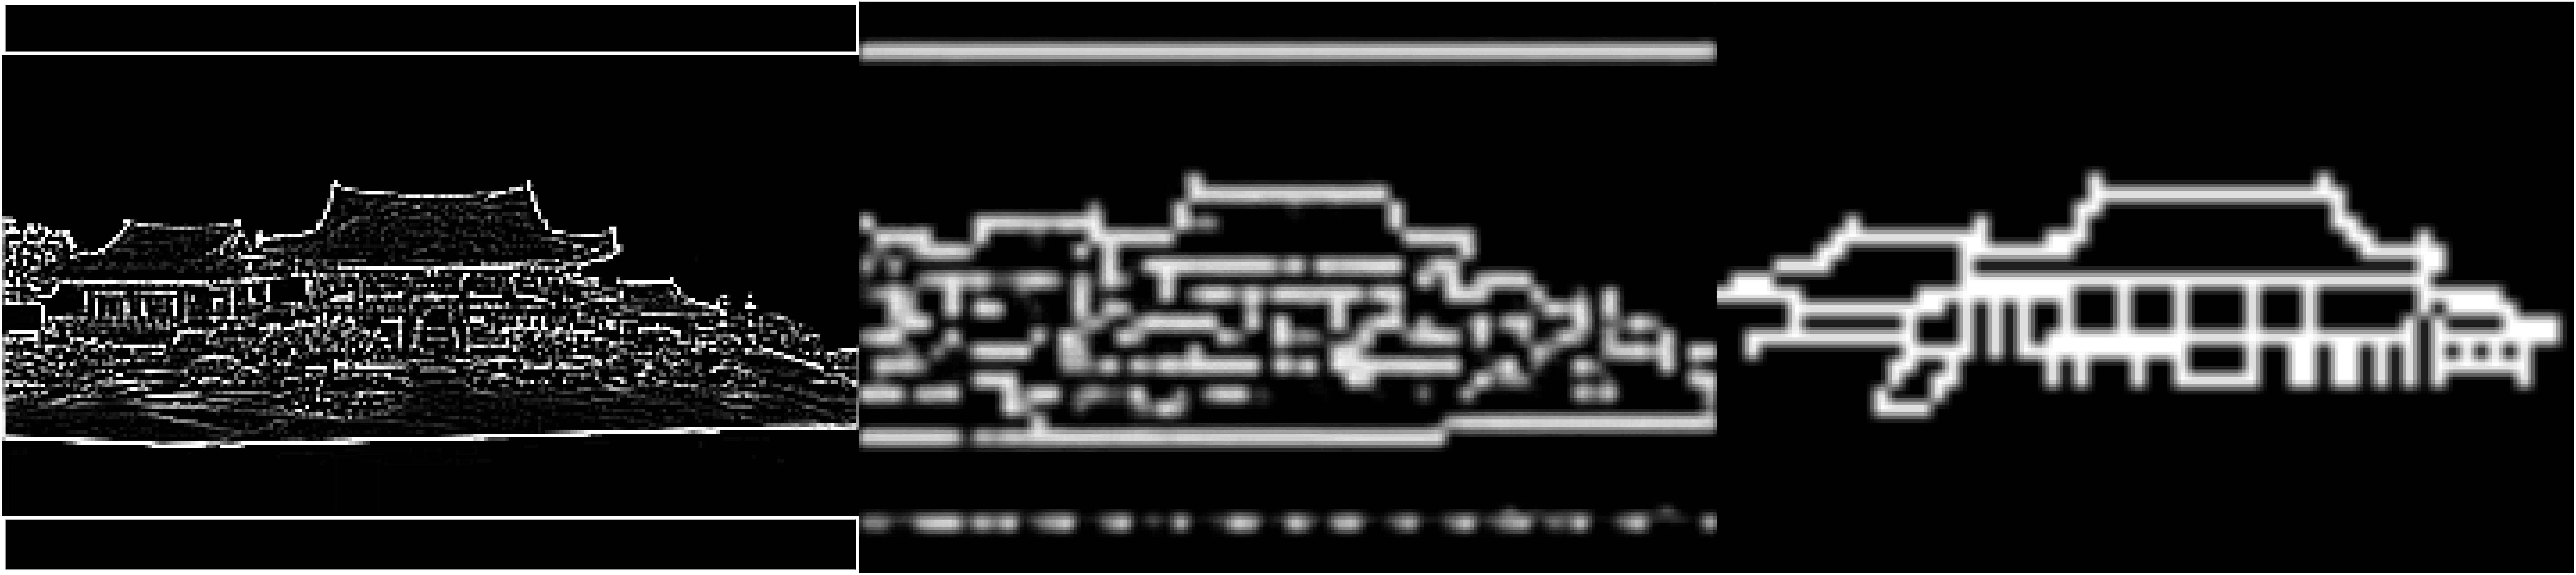

[Epoch 150/500] [D loss: 0.247] [G pixel loss: 0.009, adv loss: 0.274] [Elapsed time: 679.2s]


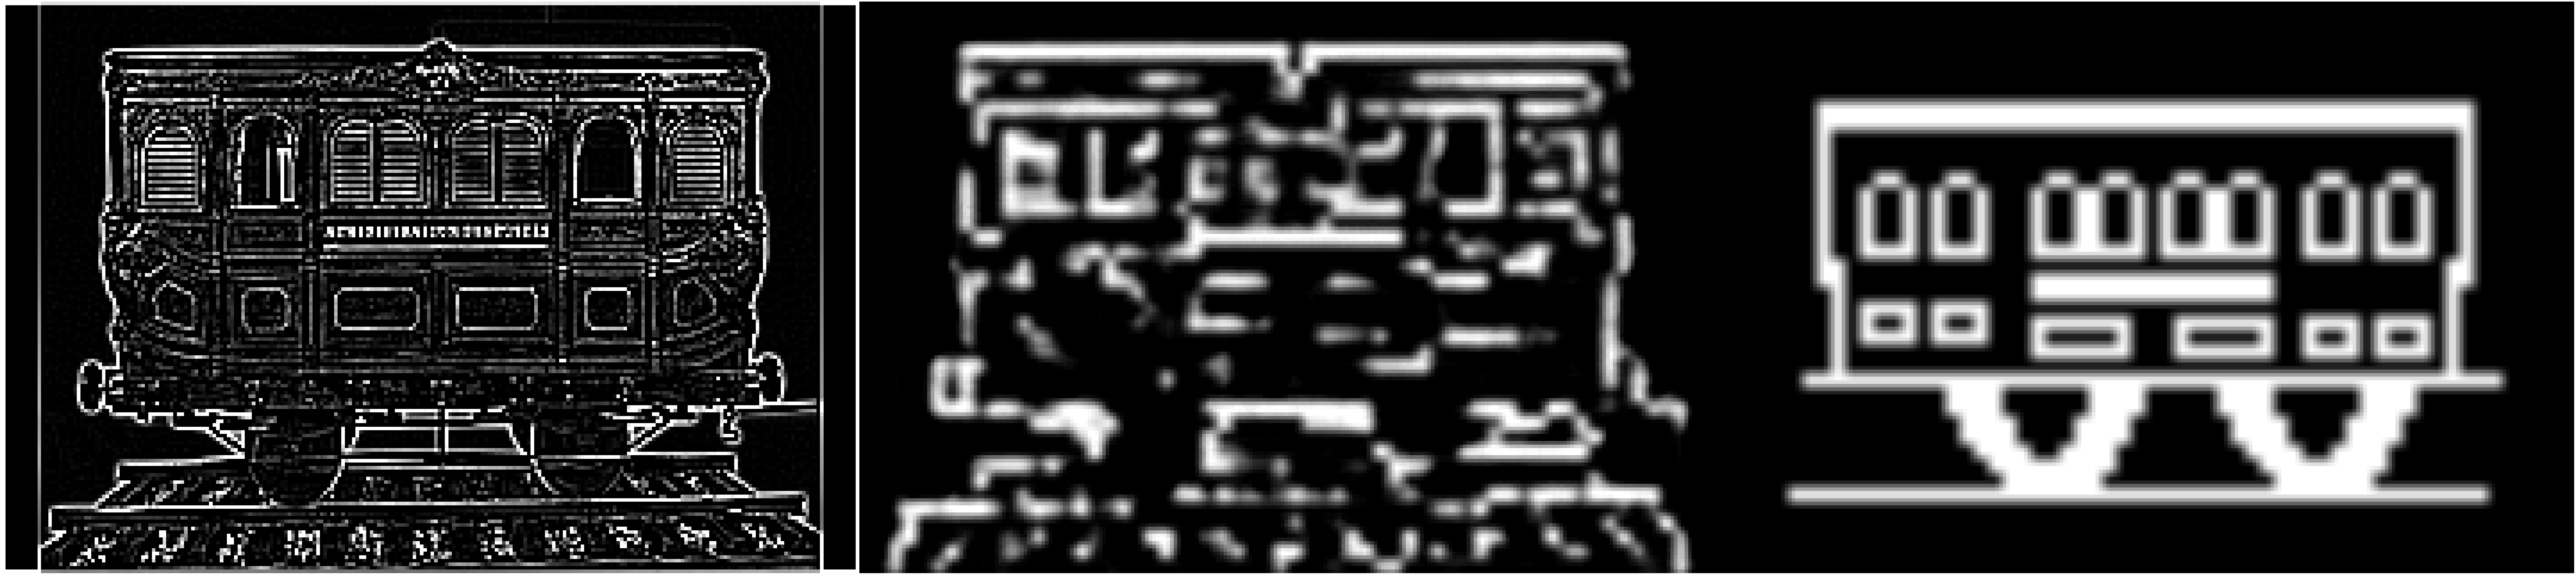

[Epoch 200/500] [D loss: 0.252] [G pixel loss: 0.009, adv loss: 0.261] [Elapsed time: 906.0s]


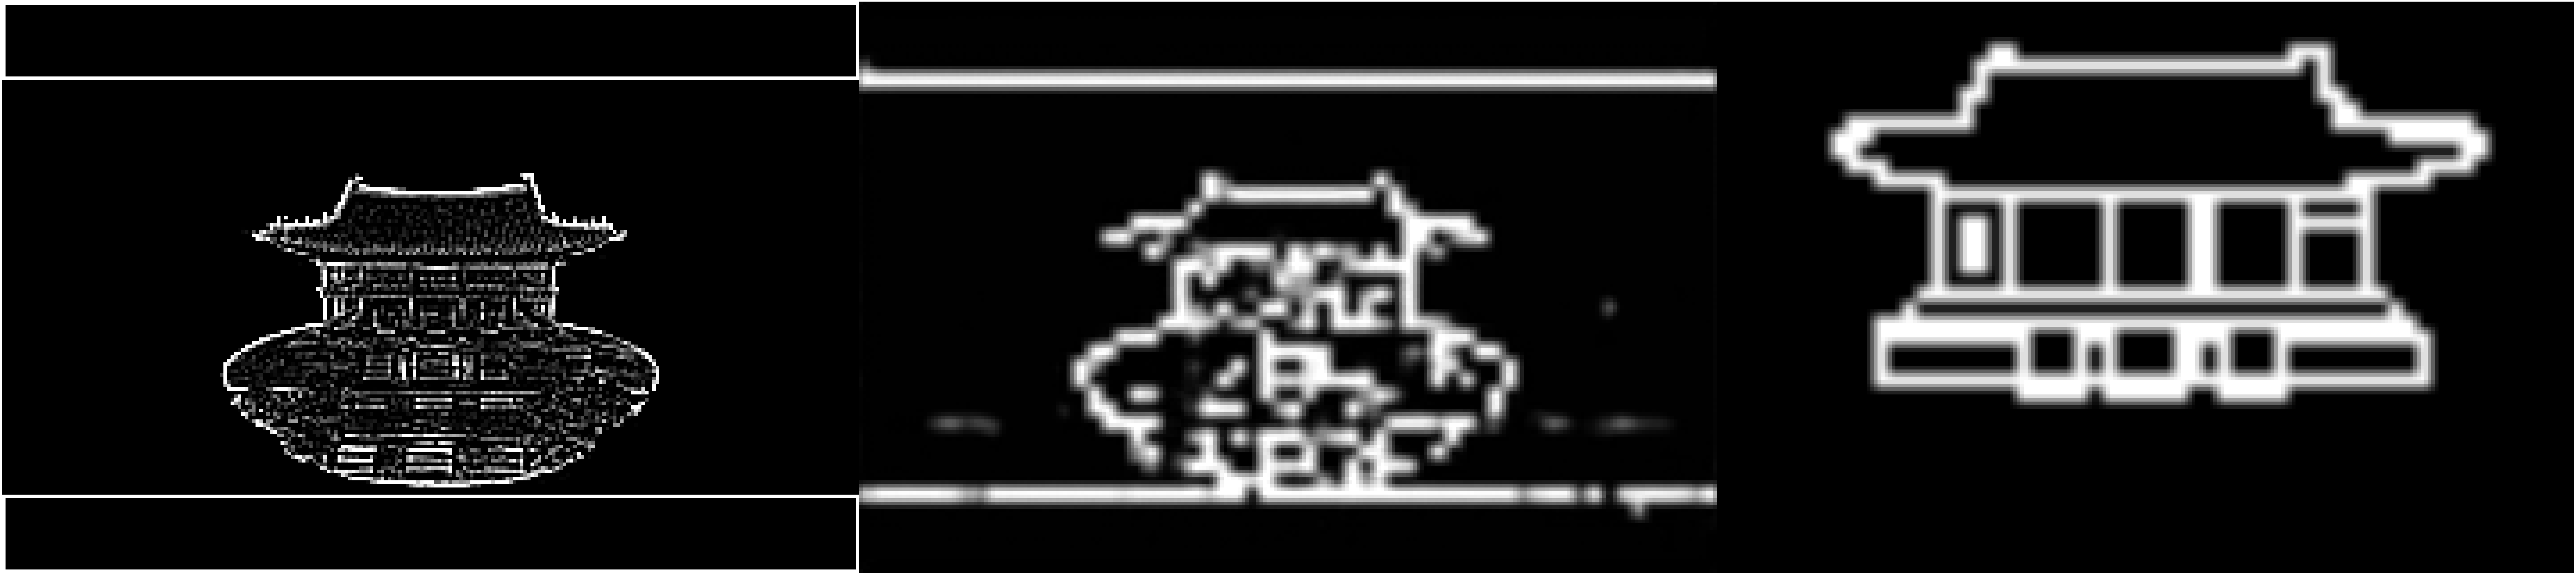

[Epoch 250/500] [D loss: 0.246] [G pixel loss: 0.006, adv loss: 0.256] [Elapsed time: 1132.1s]


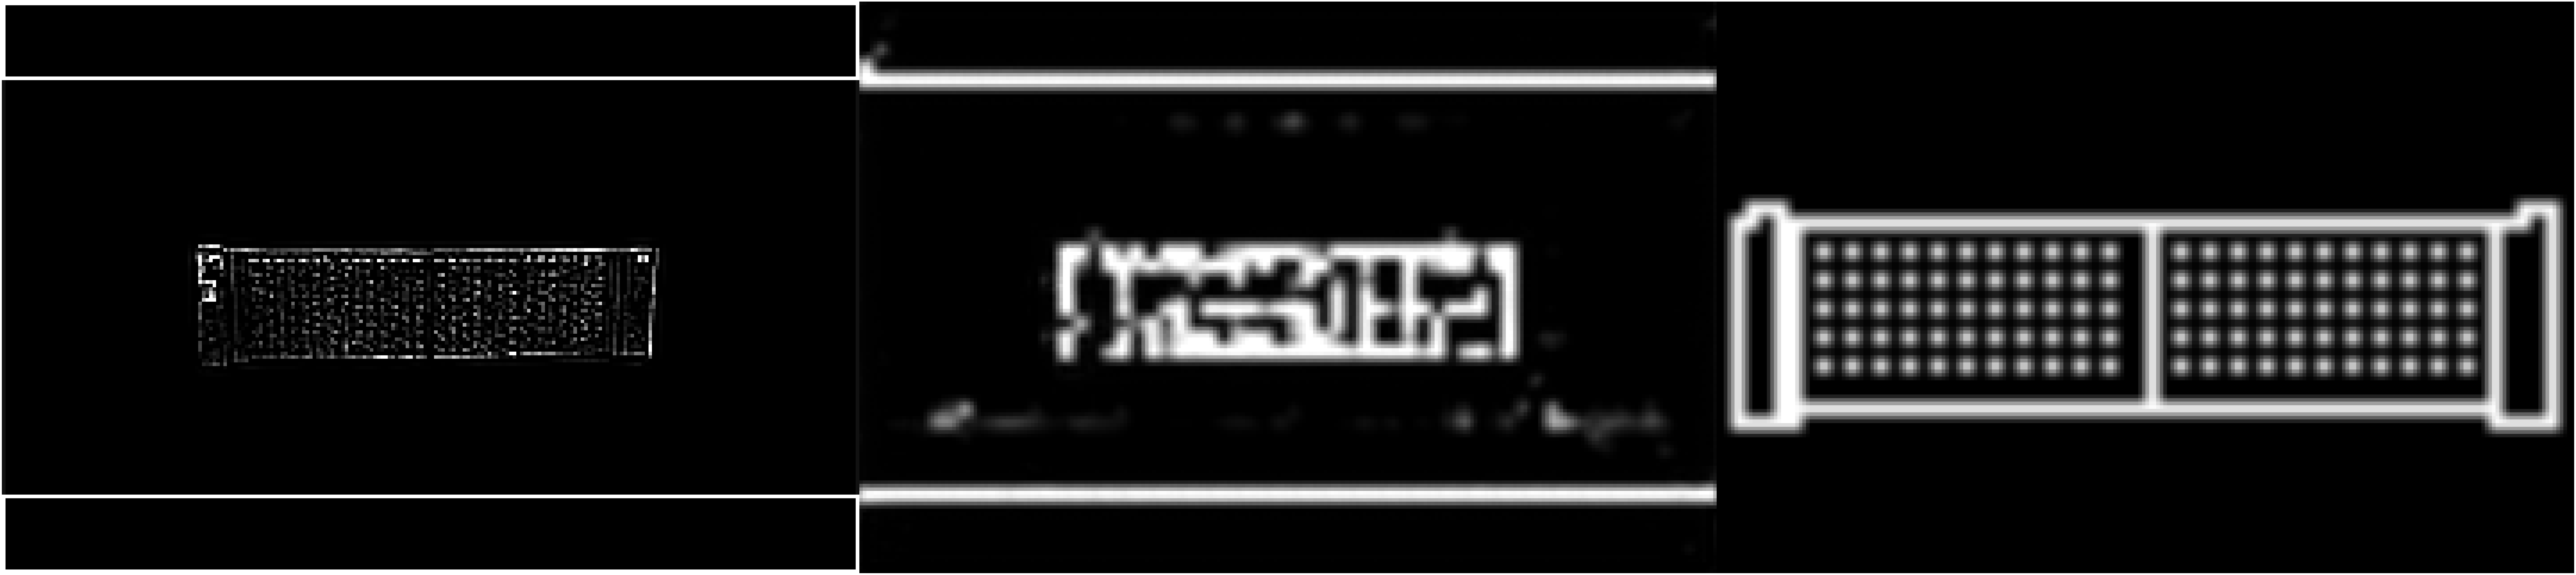

[Epoch 300/500] [D loss: 0.254] [G pixel loss: 0.005, adv loss: 0.318] [Elapsed time: 1358.7s]


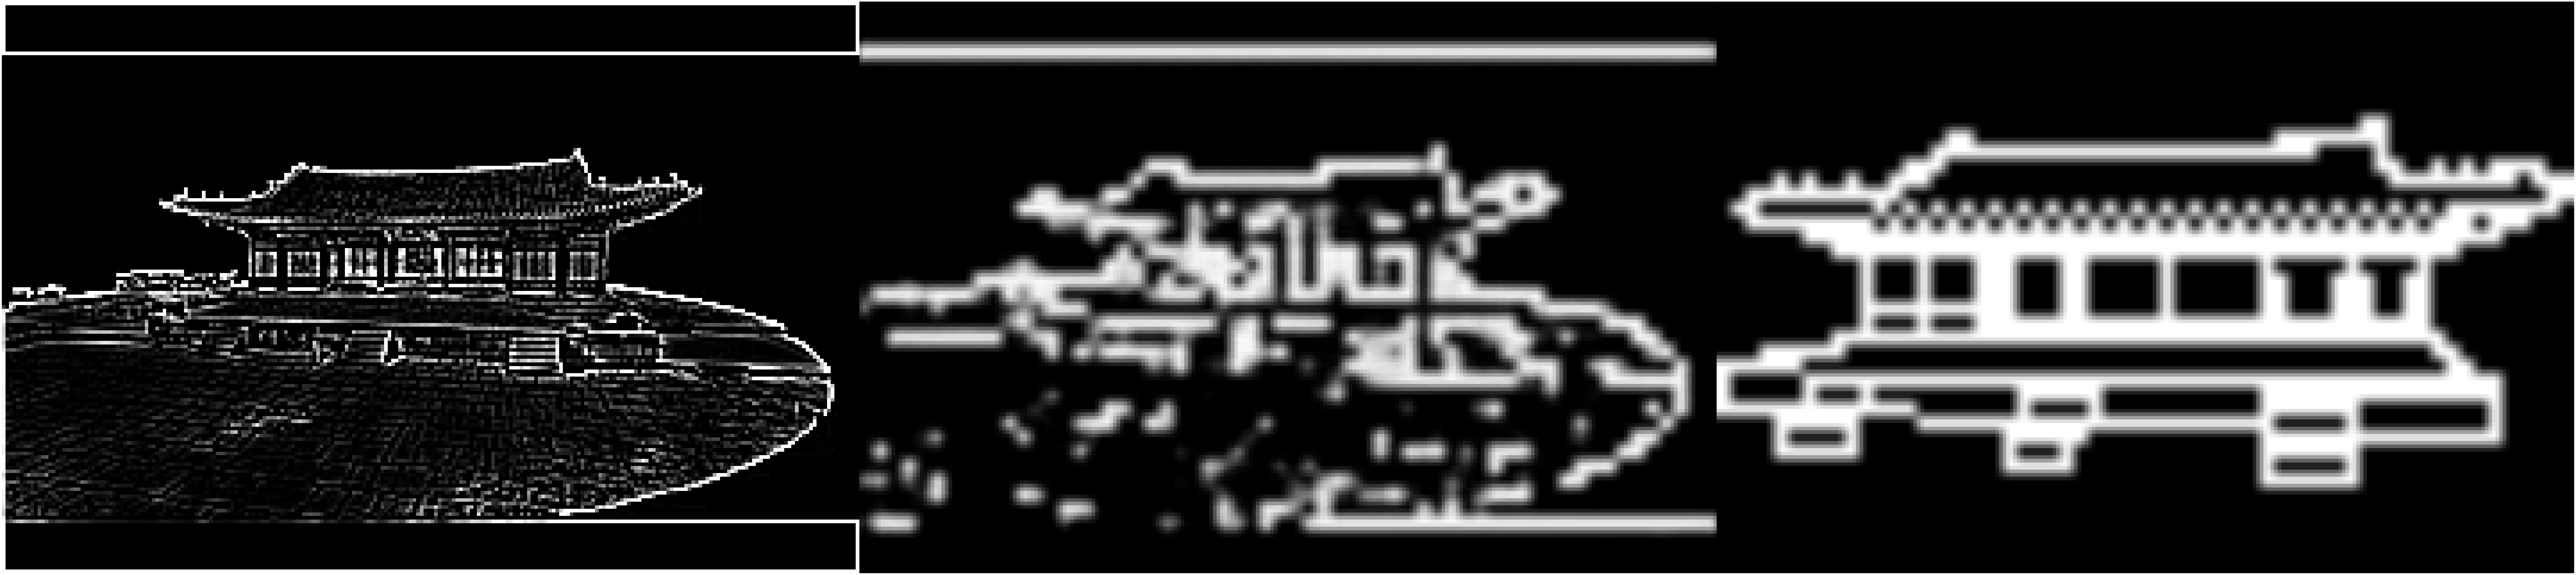

[Epoch 350/500] [D loss: 0.255] [G pixel loss: 0.004, adv loss: 0.268] [Elapsed time: 1585.6s]


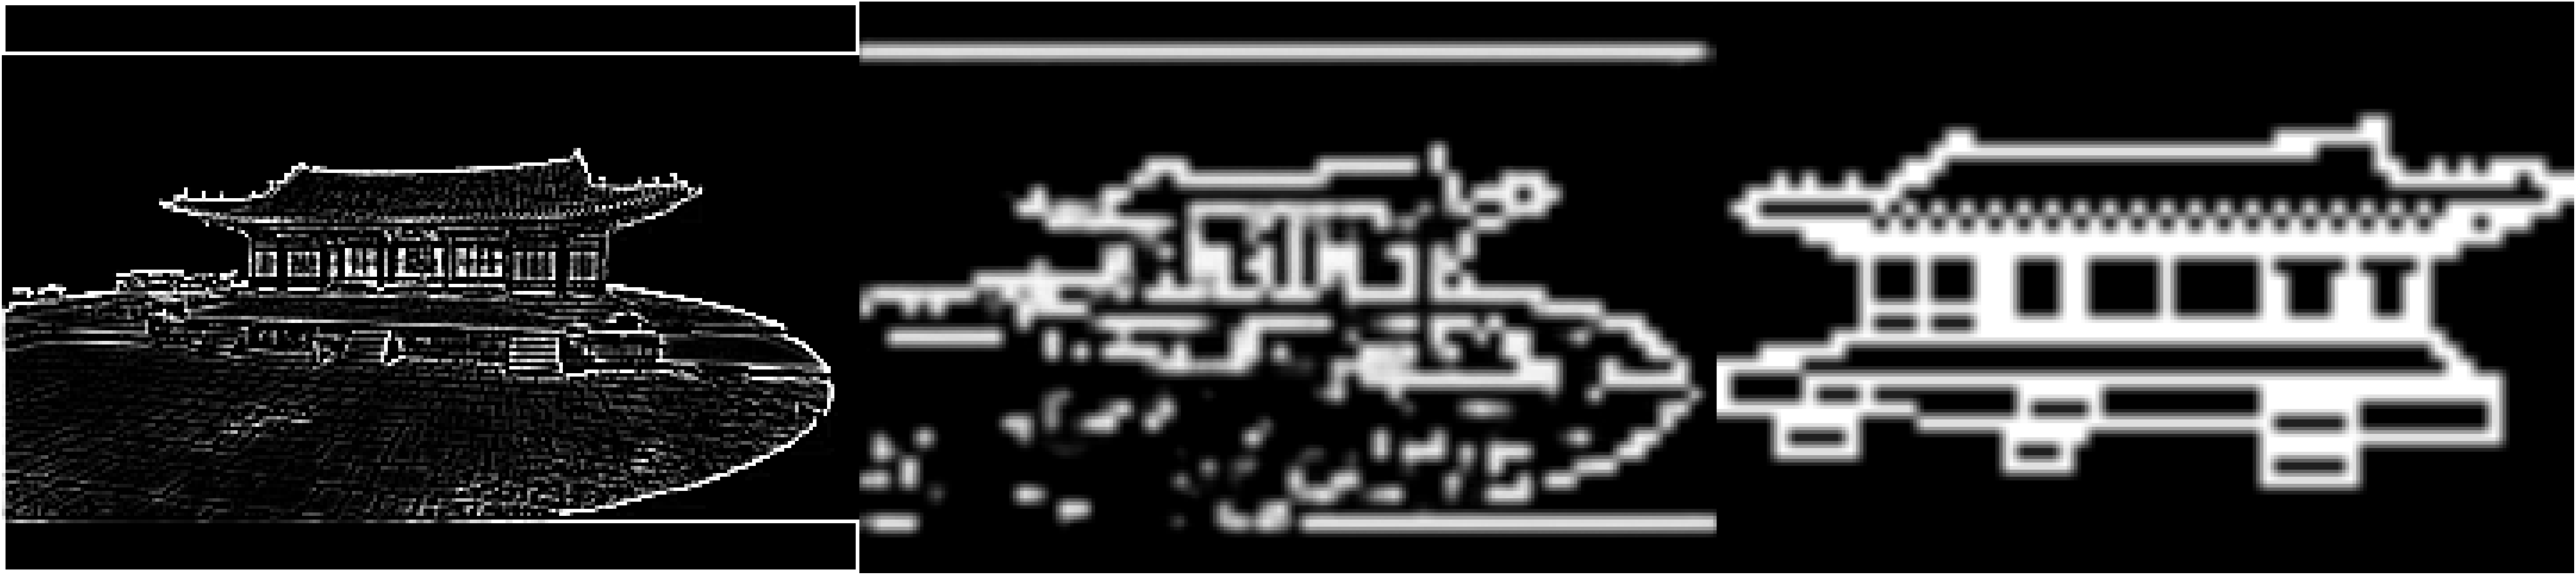

[Epoch 400/500] [D loss: 0.252] [G pixel loss: 0.006, adv loss: 0.256] [Elapsed time: 1812.2s]


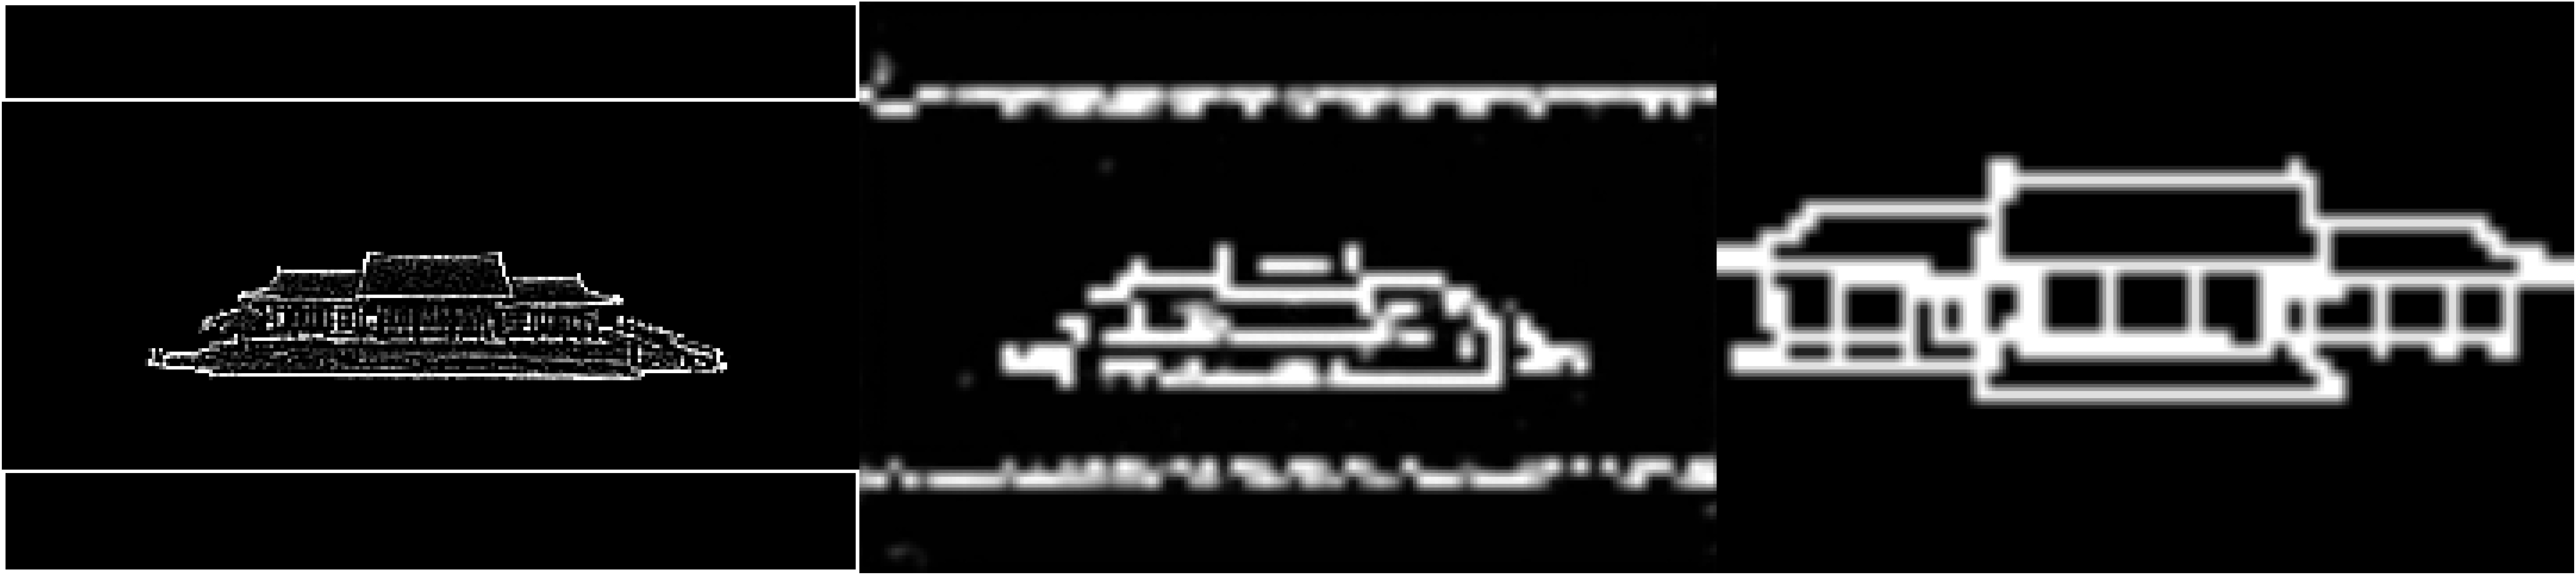

[Epoch 450/500] [D loss: 0.251] [G pixel loss: 0.005, adv loss: 0.250] [Elapsed time: 2038.8s]


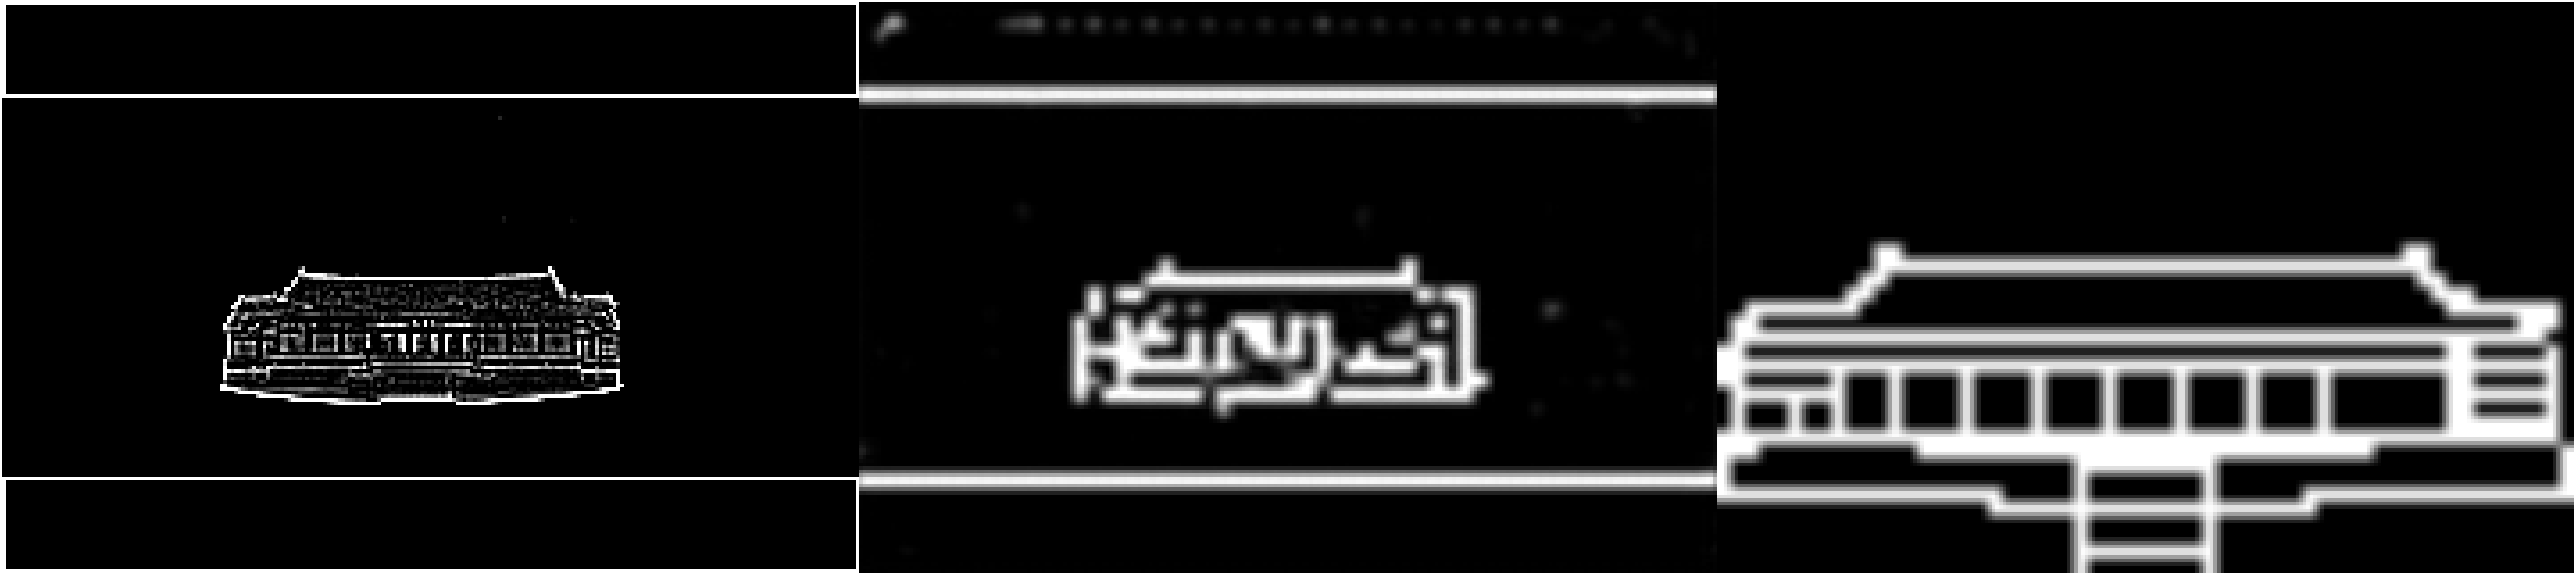

[Epoch 500/500] [D loss: 0.251] [G pixel loss: 0.003, adv loss: 0.253] [Elapsed time: 2265.8s]


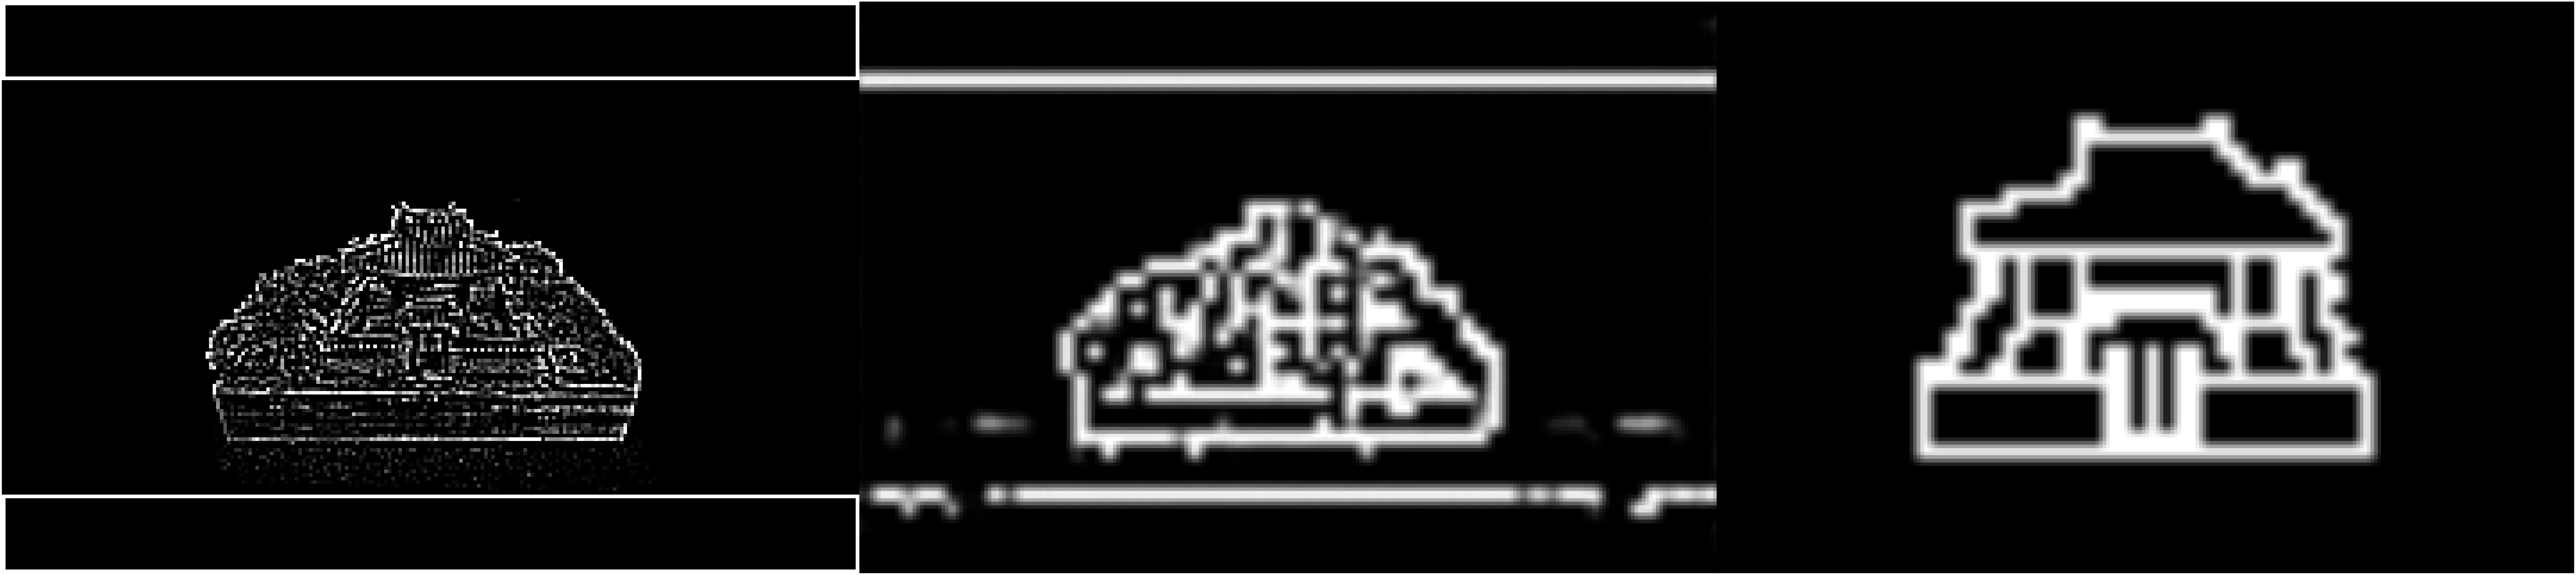

In [8]:
import time
from PIL import Image

# 메모리정리
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

def sample_show():
  imgs = next(iter(sample_dataloader))
  real_A = imgs["A"].cuda()
  real_B = imgs["B"].cuda()
  fake_B = generator(real_A)
  img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -1) # 높이(height)를 기준으로 이미지를 연결하기
  #img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
  # save_image(img_sample, "sample.png", nrow=10, normalize=True)
  save_image(img_sample, "sample.png", nrow=3)
  im1 = Image.open('sample.png')

  # plt.figure(figsize=(30*10,30*3))
  plt.figure(figsize=(60*3,40*1))
  plt.imshow(im1)
  plt.axis('off')
  plt.show()

def train(n_epochs=500, sample_interval=50, lambda_pixel=500):
  # n_epochs = 500#5000 # 학습의 횟수(epoch) 설정
  # sample_interval = 50 #200 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

  # # 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
  # lambda_pixel = 500 #100

  start_time = time.time()

  for epoch in range(n_epochs):
      for i, batch in enumerate(train_dataloader):
          # 모델의 입력(input) 데이터 불러오기
          # real_A = batch["B"].cuda()
          # real_B = batch["A"].cuda()
          real_A = batch["A"].cuda()
          real_B = batch["B"].cuda()

          # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
  #         real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
  #         fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0
          real = torch.cuda.FloatTensor(real_A.size(0), 1, 10, 15).fill_(1.0) # 진짜(real): 1
          fake = torch.cuda.FloatTensor(real_A.size(0), 1, 10, 15).fill_(0.0) # 가짜(fake): 0

          """ 생성자(generator)를 학습합니다. """
          optimizer_G.zero_grad()

          # 이미지 생성
          fake_B = generator(real_A)

  #         realcat = torch.cat([real_A, real_B], dim=1)
  #         fakecat = torch.cat([real_A, fake_B], dim=1)
  #         predG = discriminator(fakecat)
  #         real = torch.ones_like(predG)
  #         fake = torch.zeros_like(predG)
          
          # 생성자(generator)의 손실(loss) 값 계산
  #         loss_GAN = criterion_GAN(predG, real)
          loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

          # 픽셀 단위(pixel-wise) L1 손실 값 계산
          loss_pixel = criterion_pixelwise(fake_B, real_B) 

          # 최종적인 손실(loss)
          loss_G = loss_GAN + lambda_pixel * loss_pixel

          # 생성자(generator) 업데이트
          loss_G.backward()
          optimizer_G.step()

          """ 판별자(discriminator)를 학습합니다. """
          optimizer_D.zero_grad()    
          
          # 판별자(discriminator)의 손실(loss) 값 계산
  #         loss_real = criterion_GAN(discriminator(realcat), real) # 조건(condition): real_A
  #         loss_fake = criterion_GAN(discriminator(fakecat.detach()), fake)
          loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
          loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
          loss_D = (loss_real + loss_fake) / 2

          # 판별자(discriminator) 업데이트
          loss_D.backward()
          optimizer_D.step()

      # 하나의 epoch이 끝날 때마다 로그(log) 출력
      if((epoch+1)%sample_interval == 0):
        print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {loss_D.item():.3f}] [G pixel loss: {loss_pixel.item():.3f}, adv loss: {loss_GAN.item():.3f}] [Elapsed time: {time.time() - start_time:.1f}s]")
        sample_show()

In [9]:
train(n_epochs=500, sample_interval=50, lambda_pixel=500)

# # 모델 파라미터 저장
torch.save(generator.state_dict(), "Pix2Pix_Generator_for_pix2pix_100.pt")
torch.save(discriminator.state_dict(), "Pix2Pix_Discriminator_for_pix2pix_100.pt")
print("Model saved!")

# # 모델 파라미터 다운로드
# from google.colab import files

# files.download('Pix2Pix_Generator_for_pix2pix_100.pt')
# files.download('Pix2Pix_Discriminator_for_pix2pix_100.pt')


Model saved!


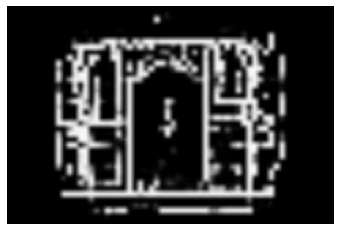

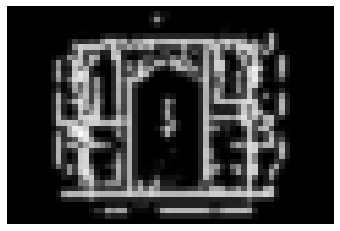

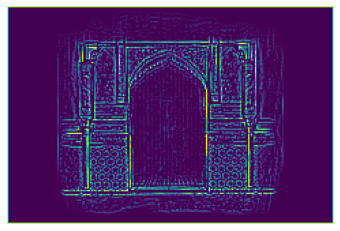

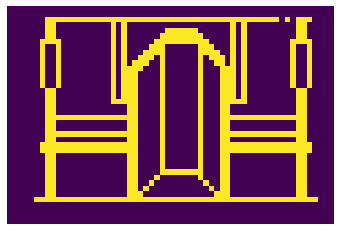

In [27]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator2 = UNet()
generator2.load_state_dict(torch.load("Pix2Pix_Generator_for_pix2pix_100.pt"))
# discriminator2.load_state_dict(torch.load("Pix2Pix_Discriminator_for_pix2pix_100.pt"))

generator2.eval();
# discriminator2.eval();

from torchvision.transforms import ToTensor, ToPILImage, Normalize
from PIL import Image
import numpy as np

imgA = getImg("./color-png/4.png")
imgB = getDtm("./color-png/4.dtm")
# imgA = getImg("./edge-png/1_1_A.png")
# imgB = getDtm("./edge-png/1_1_A.dtm")

imgTemp = ToTensor()(imgA).reshape(1,1,160,240)
# imgTemp = Normalize((0.5), (0.5))(imgTemp)
fake_B = generator2(imgTemp)

save_image(fake_B, "result.png")
im2 = Image.open('result.png')

plt.imshow(im2)
plt.axis('off')
plt.show()

plt.imshow(im2.resize((60,40)))
plt.axis('off')
plt.show()

plt.imshow(imgA)
plt.axis('off')
plt.show()

plt.imshow(imgB)
plt.axis('off')
plt.show()
